## X-ray diffraction analysis


In [ ]:
pip install pymatgen 

Enter the name of the measurements file: CuAg_meas.txt
Enter the spacing (or press Enter for default): 25
Enter the minimum difference (or press Enter for default): 1
Enter the name of the background file (or press enter for no background): CuAg_back.txt
Enter the name of the CIF file of phase1: Cu.cif
Enter the name of phase1: Cu
Enter the name of the CIF file of phase2 (or type 'None'): Ag.cif
Enter the name of phase2(or type 'None'): Ag
Enter the name of the CIF file of phase3(or type 'None'): 'None'
Enter the name of phase3(or type 'None'): 'None'
Enter the x limit as x_start x_finish:20 100


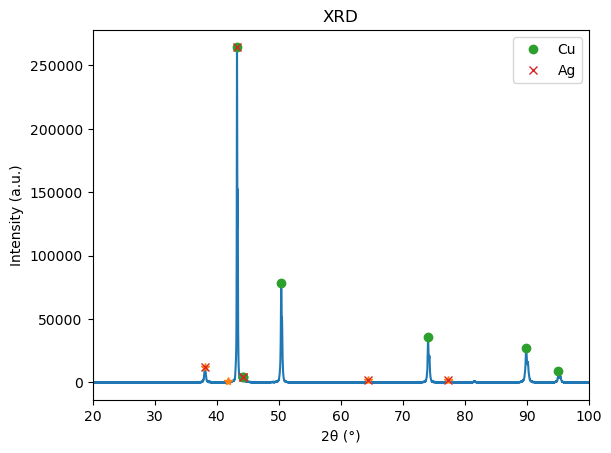

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from itertools import zip_longest
import csv

def xrdpeaks(filename, spacing= None, min_diff=1, background=None, reference1=None, name1=None, reference2=None, name2=None, reference3=None, name3=None, x_limit=None):
    '''
    The function is capable of plotting the experimental results, finding peaks, associate them to a reference phase and prints the angle-intensity values of each peak.
    The requested input 'filename' is a '.txt' or '.csv' file for the experimental data
    Optionally the following inputs can be added for further refinement of the result:
    'spacing': integer number to the minimum distance between two peaks to have both counted
    'min_diff': real number to specify how prominent a peak has to be to have it counted
    'background': '.txt' or '.csv' file whose values are subtracted to the intensity values of 'filename'
    'reference1': '.cif' file associated to a material phase for which the user is looking for matching peaks
    'name1': name of the material phase of 'reference1'
    the next four optional inputs are '.cif' file and name of other two material phases for which the user is looking for matching peaks
    '''
    if filename[-3:] == 'txt':
        with open(filename, 'r') as file:
            lines = file.readlines()
            x = []
            y = []
            for line in lines:
                try:
                    values = line.strip().split()
                    x.append(float(values[0]))
                    y.append(float(values[1]))
                except ValueError:
                      pass 

            angle = np.array(x) 
    elif filename[-3:] == 'csv':
        with open(filename, 'r') as file_csv:
            csv_reader = csv.reader(file_csv)
            x = []
            y = []
            for row in csv_reader:
                    try:
                        x.append(float(row[0].replace(',', '.')))                            
                        y.append(float(row[1].replace(',', '.')))
                    except ValueError:
                        pass
                    angle = np.array(x) 

                
    if spacing is None:
        spacing = int((angle.shape[0])/25)

    intensity_noBG = np.array(y)

    if background is None or background.lower() == 'none' or not background.strip():
        background = np.zeros(intensity_noBG.shape)
    else:
        with open(background, 'r') as file:
            lines = file.readlines()

            data_lines = lines[2:]
            x1 = []
            y1 = []
            for line in data_lines:
                values = line.strip().split()
                x1.append(float(values[0]))
                y1.append(float(values[1]))

            background = np.array(y1)

    intensity = np.subtract(intensity_noBG, background)


    peaksang = []
    peaksint = []
    for i in list(range(len(angle))): 
        if i-spacing < 0:
             if intensity[i] == max(intensity[0:i+spacing+1]) and intensity[i] > min_diff*abs((min(intensity[0:i+spacing+1])+1000)): # abs because after removing the background there might be negative values; +1 because if 0 there is no effect
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]
        elif i+spacing>len(angle):
            if intensity[i] == max(intensity[i-spacing:]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:])+1000)):
               peaksang = peaksang + [angle[i]]
               peaksint = peaksint + [intensity[i]]
        else:
            if intensity[i] == max(intensity[i-spacing:i+spacing]) and intensity[i] > min_diff*abs((min(intensity[i-spacing:i+spacing])+1000)):
                peaksang = peaksang + [angle[i]]
                peaksint = peaksint + [intensity[i]]

    # PLOTTING
    plt.plot(angle,intensity)
    plt.plot(peaksang, peaksint, "*")
    plt.ylabel('Intensity (a.u.)')
    plt.xlabel('2θ (°)')
    plt.title('XRD')
    if x_limit is not None:
        x_limit = [float(x) for x in x_limit.split()]
        plt.xlim(x_limit)

    # MATCHING
    # reference1
    if reference1 is not None and reference1[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure1 = Structure.from_file(reference1)
      phase1 = xrd_calculator.get_pattern(structure1, two_theta_range=(angle[0], angle[-1])) 
      match1 = []
      remaining1 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase1.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match1.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining1.append(a1)
      phase1_int = [peaksint[peaksang.index(angle)] for angle in match1]
      plt.plot(match1,phase1_int, "o", label = name1)

    # reference2
    if reference2 is not None and reference2[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure2 = Structure.from_file(reference2)
      phase2 = xrd_calculator.get_pattern(structure2, two_theta_range=(angle[0], angle[-1])) 
      match2 = []
      remaining2 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase2.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match2.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining2.append(a1)
      phase2_int = [peaksint[peaksang.index(angle)] for angle in match2]
      plt.plot(match2,phase2_int, "x", label = name2)

    # reference3
    if reference3 is not None and reference3[-3:] == 'cif':
      xrd_calculator=XRDCalculator()
      structure3 = Structure.from_file(reference3)
      phase3 = xrd_calculator.get_pattern(structure3, two_theta_range=(angle[0], angle[-1])) 
      match3 = []
      remaining3 = []
      for a1 in peaksang:
          found_match = False
          for a2 in phase3.x:
              if a2 is not None and a2 - 1.5 <= a1 <= a2 + 1.5:
                  match3.append(a1)
                  found_match = True
                  break
              if not found_match:
                 remaining3.append(a1)
      phase3_int = [peaksint[peaksang.index(angle)] for angle in match3]
      plt.plot(match3,phase3_int, "o", label = name3)

    plt.legend()
    plt.show()
    plt.savefig(input("Enter the name of the plot: "))

    # PRINTING
    angle_label = np.array(["Angle [°]:"], dtype=object)
    angletoprint = np.concatenate((angle_label,peaksang))
    intensity_label = np.array(["Intensity [a.u.]:"], dtype=object)
    inttoprint = np.concatenate((intensity_label,peaksint))
    max_length = max(len(angletoprint), len(inttoprint)) 
    
    for ang, inten in zip_longest(angletoprint, inttoprint, fillvalue=""): 
        ang_str = str(ang)
        int_str = str(inten)
        print(f"{ang_str:<15s} {int_str}")

    return peaksang, peaksint

filename = input("Enter the name of the measurements file: ")
spacing = input("Enter the spacing (or press Enter for default): ")
min_diff = input("Enter the minimum difference (or press Enter for default): ")
background = input("Enter the name of the background file (or press enter for no background): ")
reference1= input("Enter the name of the CIF file of phase1: ")
name1= input("Enter the name of phase1: ")
reference2= input("Enter the name of the CIF file of phase2 (or type 'None'): ")
name2= input("Enter the name of phase2(or type 'None'): ")
reference3= input("Enter the name of the CIF file of phase3(or type 'None'): ")
name3= input("Enter the name of phase3(or type 'None'): ")
x_limit= (input("Enter the x limit as x_start x_finish:"))

spacing = int(spacing) if spacing else None
min_diff = float(min_diff) if min_diff else 1


peaksang, peaksint = xrdpeaks(filename, spacing, min_diff, background, reference1, name1, reference2, name2, reference3, name3, x_limit)

